In [1]:
# default_exp analyses

# Benchmark Recall Phenomena

Work such as Kahana (2020) and Morton & Polyn, 2016 identify a few benchmark recall phenomena characterizing patterns in the way people typically perform free (and serial) recall, including

1. Recall probability as a function of serial position
2. Probability of starting recall with each serial position
3. Conditional response probability as a function of lag

We'll demo these in this notebook, constructing functions for data in the long table format [recommended by the psifr toolbox](https://psifr.readthedocs.io/en/latest/guide/import.html). 

While the psifr library includes its own set of functions for visualizing these curves, we usually default to using the library to extract dataframes containing relevant statistics and creating the visualizations ourselves. This is to obtain full access to `seaborn`'s features by making psifr's plotting functions _mappable_ to figures according to `seaborn` or `matplotlib`'s internal logic.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Loading Data
For our demonstrations, we'll lean on the MurdockOkada1970 Dataset. As a reminder, in this dataset each of 72 undergraduates was given 20 test lists with 20-word lists visually presented at either 60 or 120 words/min.

In [3]:
from compmemlearn.datasets import prepare_murdock1970_data

trials, events, list_length = prepare_murdock1970_data('../../data/mo1970.txt')
events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,NaN,True,False,0,False
1,1,1,2,2,NaN,True,False,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


## Serial Position Curve
The serial position effect describes how our memory is affected by the position of information in a sequence. It suggests that we best remember the first and last items in a series and find it hard to remember the middle items. To measure the serial position effect, we find across a sample for each study -- serial -- position in a list the rate at which the item is ultimately recalled in the list. Then we plot this rate across positions.

In [15]:
# export
from psifr import fr
import seaborn as sns

def plot_spc(data, **facet_kws):
    
    sns.lineplot(
        data=fr.spc(data), x='input', y='recall', **facet_kws)

In [16]:
spc = fr.spc(events)
spc.head()

recall
subject input        
1       1        0.40
        2        0.10
        3        0.25
        4        0.30
        5        0.10

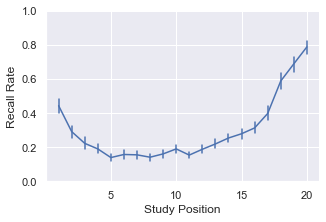

In [17]:
g = sns.FacetGrid(dropna=False, data=events, aspect=1.5)
g.map_dataframe(plot_spc, err_style='bars')
g.set_xlabels('Study Position')
g.set_ylabels('Recall Rate')
g.set(ylim=(0, 1))

plt.show()

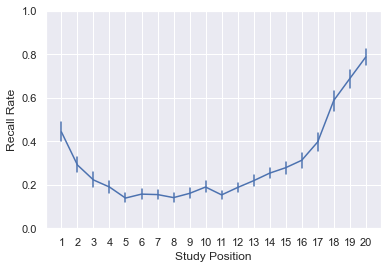

In [18]:
plot_spc(events, err_style='bars')
plt.xlabel('Study Position')
plt.ylabel('Recall Rate')
plt.xticks(np.arange(1, 21), np.arange(1, 21))
plt.ylim((0, 1))
plt.show()

If we want, we can draw a unique SPC for each subject in our dataset too:

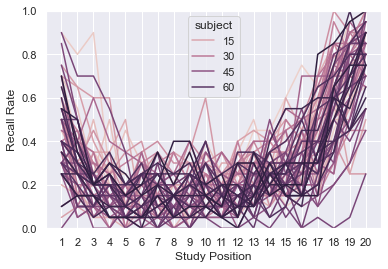

In [19]:
plot_spc(events, err_style='bars', hue='subject')
plt.xlabel('Study Position')
plt.ylabel('Recall Rate')
plt.xticks(np.arange(1, 21), np.arange(1, 21))
plt.ylim((0, 1))
plt.show()

## Lag CRP
The contiguity effect illustrates how episodic associations are graded, exhibiting power-function decay with increasing lag. Recall of an item has a tendency to evoke not only adjacent list items, but other nearby items as well. In addition, episodic associations appear to be asymmetrical, favoring retrieval of items in the forward order.

To measure the contiguity effect, we often produce lag-CRP curves. "Lag-CRP" measures the conditional probability of recalling an item as a function of its adjacency (**lag**) in the study list to the the last recalled item. To find this in our free recall data, for every recall a participant made in a dataset, we measure how adjacent the recalled item was from the *next* item the participant recalled -- its serial lag. For example, if a subject recalls the third item presented in a list and then the fourth, the lag of the next item recalled is +1. If a subject instead recalls the first item after recalling the third item, the measured lag is -2. We also track across recalls which lag transitions were possible based on which items were not already retrieved. Once we've tallied up all actual and possible lag transitions across a dataset, we plot for each lag the ratio of actual transitions divided by position transitions to visualize the conditional probability of each lag transition.

In [20]:
# export

def plot_lag_crp(data, max_lag=5, **facet_kws):
    
    filt_neg = f'{-max_lag} <= lag < 0'
    filt_pos = f'0 < lag <= {max_lag}'
    
    crp_data = fr.lag_crp(data)
    
    sns.lineplot(
        data=crp_data.query(filt_neg), 
        x='lag', y='prob', **facet_kws)
    sns.lineplot(
        data=crp_data.query(filt_pos), 
        x='lag', y='prob', **facet_kws)

In [21]:
lag_crp = fr.lag_crp(events)
lag_crp.head()

prob  actual  possible
subject lag                            
1       -19  0.166667       2        12
        -18  0.083333       2        24
        -17  0.025641       1        39
        -16  0.019608       1        51
        -15  0.030303       2        66

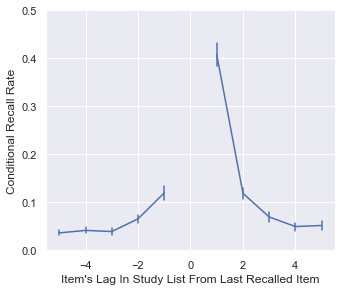

In [22]:
sns.set_theme(style="darkgrid")

g = sns.FacetGrid(dropna=False, data=events, height=4, aspect=1.2)
g.map_dataframe(plot_lag_crp, err_style='bars')
g.set(ylim=(0, .5))

g.set_xlabels('Item\'s Lag In Study List From Last Recalled Item')
g.set_ylabels('Conditional Recall Rate')

plt.show()

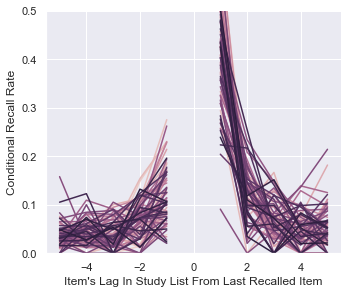

In [23]:
sns.set_theme(style="darkgrid")

g = sns.FacetGrid(dropna=False, data=events, height=4, aspect=1.2)
g.map_dataframe(plot_lag_crp, err_style='bars', hue='subject')
g.set(ylim=(0, .5))

g.set_xlabels('Item\'s Lag In Study List From Last Recalled Item')
g.set_ylabels('Conditional Recall Rate')

plt.show()

## Probability of First Recall by Serial Position

In [24]:
# export

def plot_pfr(data, max_lag=5, **facet_kws):
    
    filt_neg = f'{-max_lag} <= lag < 0'
    filt_pos = f'0 < lag <= {max_lag}'
    
    pfr_data = fr.pnr(data).query('output <= 1')
    
    sns.lineplot(
        data=pfr_data, x='input', y='prob', **facet_kws)
    sns.lineplot(
        data=pfr_data, x='input', y='prob', **facet_kws)

In [25]:
pfr = fr.pnr(events).query('output <= 1').reset_index()
pfr.head()

,subject,output,input,prob,actual,possible
0,1,1,1,0.0,0,20
1,1,1,2,0.0,0,20
2,1,1,3,0.0,0,20
3,1,1,4,0.0,0,20
4,1,1,5,0.0,0,20


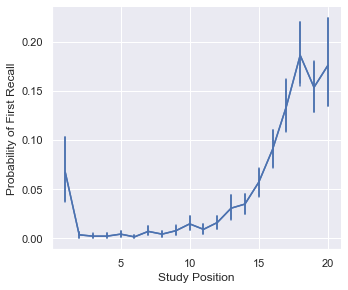

In [26]:
g = sns.FacetGrid(dropna=False, data=events, height=4, aspect=1.2)
g.map_dataframe(plot_pfr, err_style='bars')

g.set_xlabels('Study Position')
g.set_ylabels('Probability of First Recall')

plt.show()

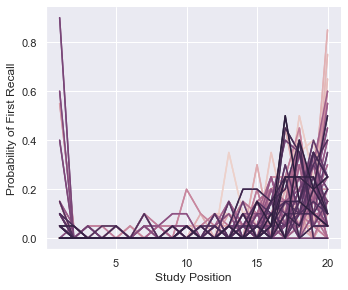

In [27]:
g = sns.FacetGrid(dropna=False, data=events, height=4, aspect=1.2)
g.map_dataframe(plot_pfr, err_style='bars', hue='subject')

g.set_xlabels('Study Position')
g.set_ylabels('Probability of First Recall')

plt.show()

## Combined Summary Plot
We usually present these together in one figure. `matplotlib`'s subplots function handles this reasonably well.

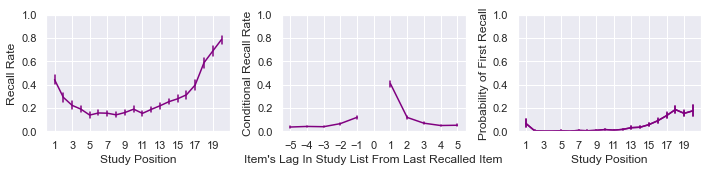

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2.5), sharey=False)

# serial position curve
plot_spc(events, err_style='bars', color='purple', ax=axes[0])
axes[0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0].set_xticks(np.arange(1, 21, 2))
axes[0].set_ylim((0, 1))

# lag crp curve
plot_lag_crp(events, err_style='bars', color='purple', ax=axes[1])
axes[1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1].set_xticks(np.arange(-5, 6, 1))
axes[1].set_ylim((0, 1))

# pfr
plot_pfr(events, err_style='bars', ax=axes[2], color='purple')
axes[2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2].set_xticks(np.arange(1, 21, 2))
axes[2].set_ylim((0, 1))

plt.tight_layout()
plt.show()